In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# https://arxiv.org/pdf/2006.11239.pdf

import torch
from torch import optim, nn

import json
from tqdm import tqdm
from random import randint

from load_dataset import load_dataset, plot_image, load_contour
from UNet import UNet
from torchvision.transforms import v2
from matplotlib import pyplot as plt
from IPython.display import clear_output

device = "cuda"

pimages = load_dataset().to(device)
pimages.shape

with open("labels/pokedex.json") as json_data:
    data = json.load(json_data)

height = [float(str(d['profile']['height']).split()[0]) for d in data]
height = torch.tensor(height, device=device)
#height

types = [d['type'] for d in data]
all_types = list(set([d[0] for d in types]))

def get_index(tp):
    if len(tp) == 1:
        return all_types.index(tp[0]), len(all_types)
    return all_types.index(tp[0]), all_types.index(tp[1])

types = torch.tensor([get_index(t) for t in types], device=device)

contour = load_contour().to(device)
contour.shape

torch.Size([3, 386, 1, 64, 64])

In [2]:
T = 1000
beta = torch.linspace(0.001, 0.02, T, device=device)

alpha = 1 - beta

alpha_ = torch.zeros(T, device=device)

for i in range(T):
    alpha_[i] = torch.prod(alpha[0:i+1])

alpha_[-1]

tensor(2.5652e-05, device='cuda:0')

In [3]:
alpha_

tensor([9.9900e-01, 9.9798e-01, 9.9695e-01, 9.9589e-01, 9.9482e-01, 9.9373e-01,
        9.9262e-01, 9.9150e-01, 9.9036e-01, 9.8920e-01, 9.8802e-01, 9.8682e-01,
        9.8561e-01, 9.8438e-01, 9.8314e-01, 9.8187e-01, 9.8059e-01, 9.7930e-01,
        9.7798e-01, 9.7665e-01, 9.7530e-01, 9.7394e-01, 9.7255e-01, 9.7116e-01,
        9.6974e-01, 9.6831e-01, 9.6686e-01, 9.6540e-01, 9.6392e-01, 9.6243e-01,
        9.6091e-01, 9.5939e-01, 9.5784e-01, 9.5628e-01, 9.5471e-01, 9.5312e-01,
        9.5151e-01, 9.4989e-01, 9.4826e-01, 9.4660e-01, 9.4494e-01, 9.4326e-01,
        9.4156e-01, 9.3985e-01, 9.3812e-01, 9.3638e-01, 9.3463e-01, 9.3286e-01,
        9.3107e-01, 9.2927e-01, 9.2746e-01, 9.2563e-01, 9.2379e-01, 9.2194e-01,
        9.2007e-01, 9.1818e-01, 9.1629e-01, 9.1438e-01, 9.1246e-01, 9.1052e-01,
        9.0857e-01, 9.0661e-01, 9.0463e-01, 9.0264e-01, 9.0064e-01, 8.9863e-01,
        8.9660e-01, 8.9456e-01, 8.9251e-01, 8.9045e-01, 8.8837e-01, 8.8628e-01,
        8.8418e-01, 8.8207e-01, 8.7995e-

torch.Size([4, 3, 72, 72])


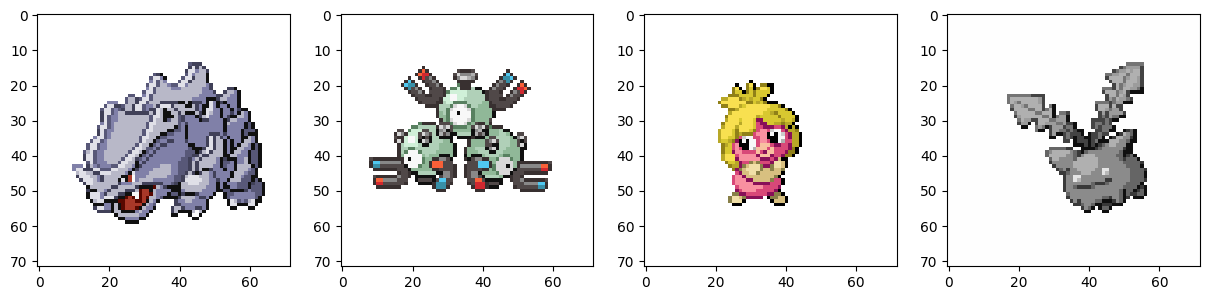

In [4]:
class Sobel():
    def __init__(self):
        self.weight = [[1, 0, -1], [0, 0, 0], [1, 0, -1]]
        self.weight = torch.tensor(self.weight, dtype=torch.float32)
        self.weight = self.weight[None, None, :, :].expand(3, -1, -1, -1)

    def __call__(self, sample):
        return nn.functional.conv2d(sample, self.weight.to(sample.device), groups=3)

pos_transform = v2.Compose([
    v2.Pad(6, 1.0),
    v2.RandomCrop((64 + 6, 64 + 6)),
    v2.Pad(1, 1.0),
    #Sobel(),

])
col_transform = v2.Compose([
    v2.RandomApply([v2.ColorJitter()], .3),
    v2.RandomApply([v2.RandomChannelPermutation()], .3),
    v2.RandomGrayscale(p = .3),
])

source = torch.randint(0, 2, (4,))
batch = torch.randperm(385)[:4]
x0 = pimages[source, batch]
x0 = torch.stack([col_transform(pos_transform(x)) for x in x0], dim=0)
print(x0.shape)


fig, axes = plt.subplots(1, 4, figsize=(15, 15))
plot_image(x0[0], axes[0])
plot_image(x0[1], axes[1])
plot_image(x0[2], axes[2])
plot_image(x0[3], axes[3])
plt.show()

In [5]:
def isigmoid(x):
    eps = 0.05
    return torch.log(x + eps) - torch.log(1 - x + eps)

In [6]:
@torch.no_grad
def generate_image():
    global model
    model.eval()

    N = 3
    
    #A = torch.tensor([300, 300, 300], device=device)
    #x0 = pimages[1, [0,151,251]]
    #x0 = torch.stack([transform(x) for x in x0], dim=0)
    #x0 = isigmoid(x0)
    #z = torch.randn_like(x0)
    #x = torch.sqrt(alpha_[A])[:, None, None, None] * x0 + torch.sqrt(1-alpha_[A])[:, None, None, None] * z

    x = torch.randn((N, 3, 72, 72), device=device)
    
    ty = [["Dark"], ["Fairy"], ["Electric"]]
    ty = torch.tensor([get_index(t) for t in ty], device=device)
    c = contour[0, [0, 151, 251]]
    c = torch.stack([pos_transform(d) for d in c], dim=0)
    
    for t in reversed(range(T)):
        tt = torch.tensor([t] * N, device=device)

        z = torch.randn_like(x)
        if t == 0:
            z *= 0

        #x0 = model(x, tt)
        #x = torch.sqrt(alpha_[t]) * x0 + torch.sqrt(1-alpha_[t]) * z

        e = model(x, tt, ty, c) * (1 - alpha[t]) / torch.sqrt(1 - alpha_[t])
        x = (1 / torch.sqrt(alpha[t])) * (x - e) + z * torch.sqrt(beta[t])

        #clear_output(wait=True)
        #fig, axes = plt.subplots(1, N, figsize=(10, 10))
        #for i in range(N):
        #    plot_image(torch.sigmoid(x-e)[i], axes[i])
        #plt.show()

    x = torch.sigmoid(x)
    
    fig, axes = plt.subplots(1, N, figsize=(10, 10))
    for i in range(N):
        plot_image(x[i], axes[i])
    plt.show()

    model.train()

In [7]:
#sd = torch.load("model.pt")
#model.load_state_dict(sd)

#generate_image()

  0%|          | 0/100001 [00:00<?, ?it/s]

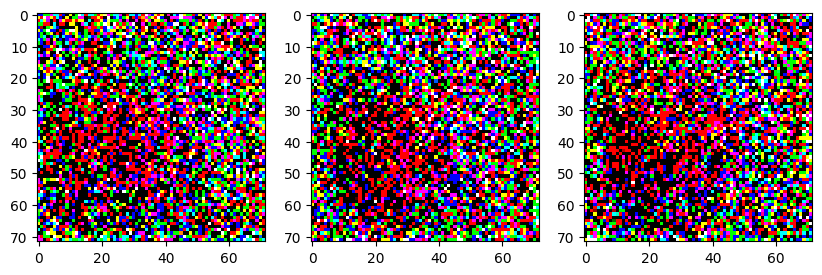

0.06525037:   1%|          | 1000/100001 [00:45<1:06:02, 24.99it/s]

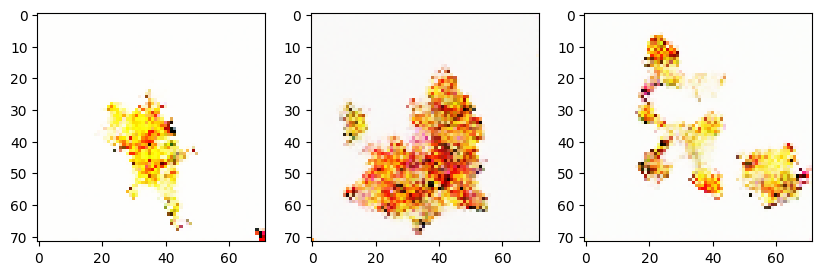

0.04767214:   2%|▏         | 1999/100001 [01:29<1:05:51, 24.80it/s] 

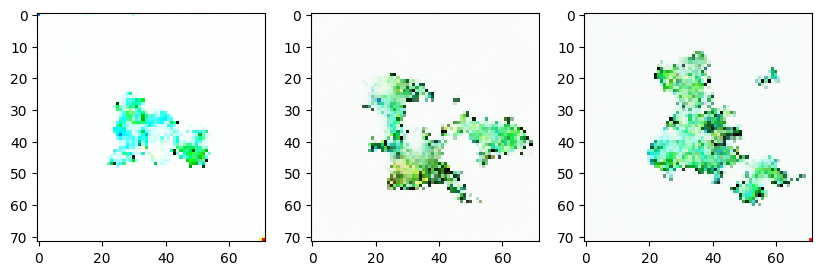

0.04466897:   3%|▎         | 2998/100001 [02:14<1:05:04, 24.85it/s] 

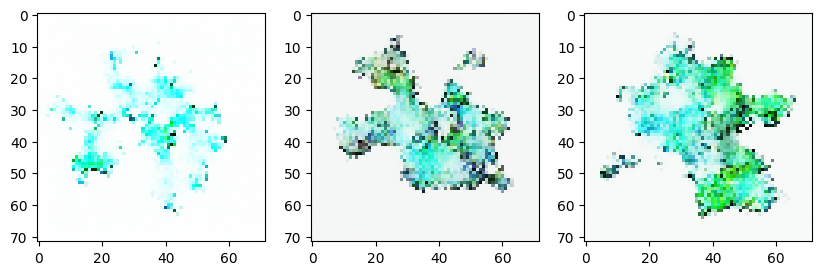

0.04574089:   4%|▍         | 4000/100001 [02:59<1:04:35, 24.77it/s] 

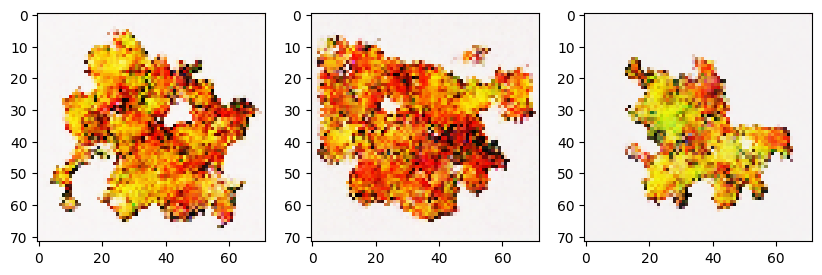

0.02511771:   5%|▍         | 4999/100001 [03:44<1:03:55, 24.77it/s] 

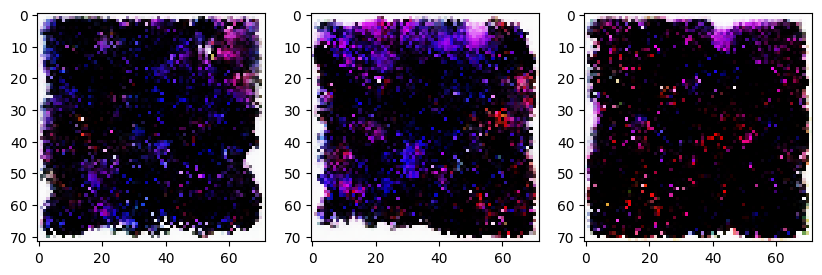

0.05115183:   6%|▌         | 5998/100001 [04:30<1:02:57, 24.88it/s] 

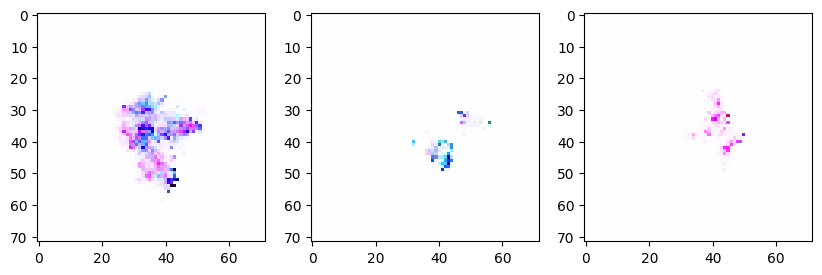

0.03686548:   7%|▋         | 7000/100001 [05:15<1:02:31, 24.79it/s] 

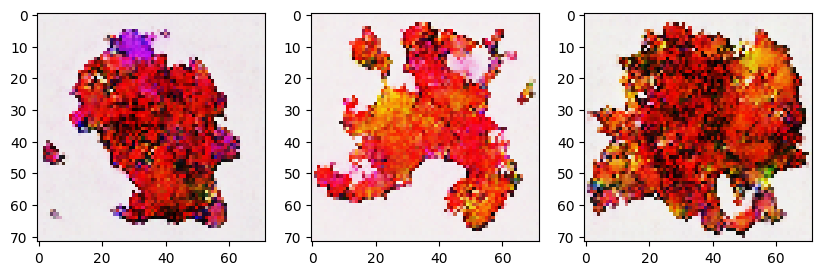

0.03138616:   8%|▊         | 7999/100001 [06:00<1:01:49, 24.80it/s] 

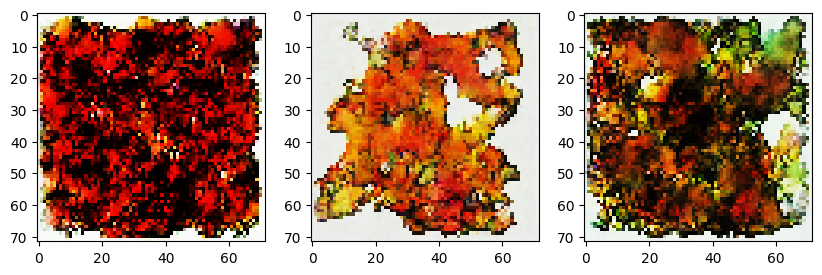

0.04046236:   9%|▉         | 8998/100001 [06:45<1:01:15, 24.76it/s] 

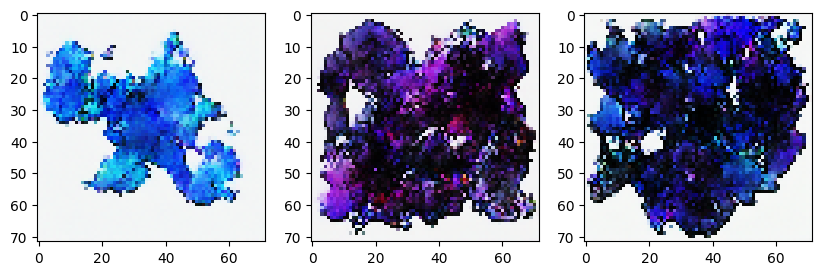

0.01727685:  10%|▉         | 10000/100001 [07:30<1:00:30, 24.79it/s]

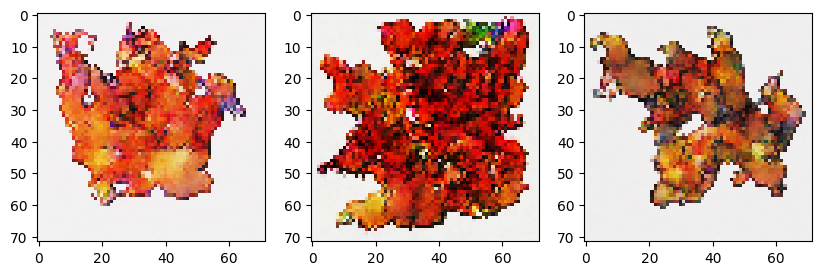

0.03228157:  11%|█         | 10999/100001 [08:15<59:50, 24.79it/s]   

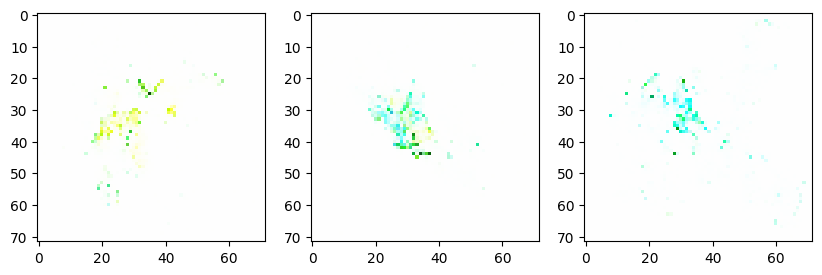

0.02032929:  12%|█▏        | 11998/100001 [09:00<59:17, 24.74it/s]   

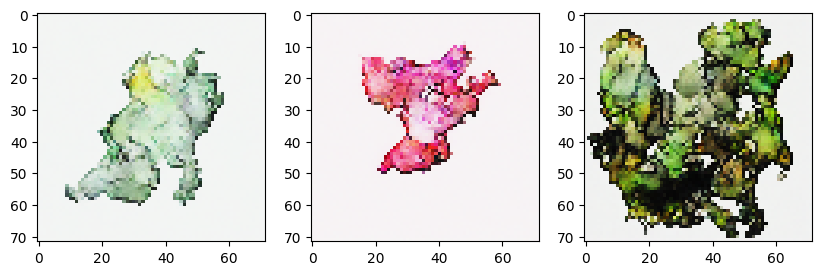

0.03945478:  13%|█▎        | 13000/100001 [09:45<58:20, 24.85it/s]   

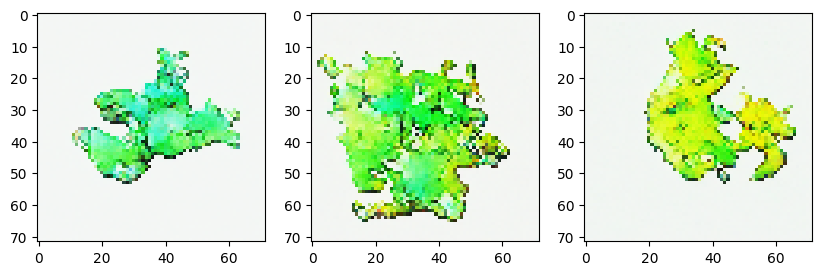

0.01950966:  14%|█▍        | 13999/100001 [10:30<57:55, 24.75it/s]   

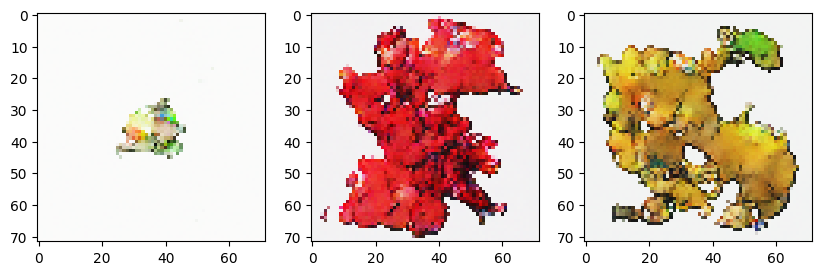

0.03450271:  15%|█▍        | 14998/100001 [11:15<56:58, 24.87it/s]   

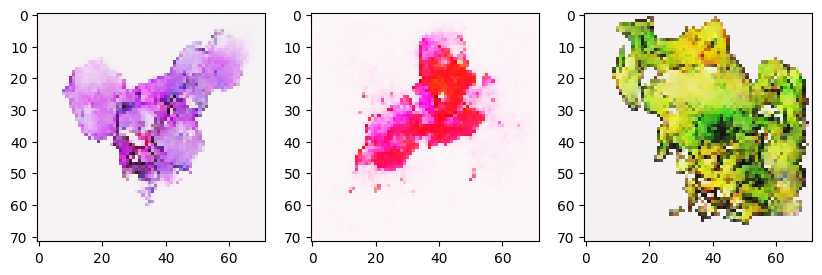

0.02043629:  16%|█▌        | 16000/100001 [12:00<56:33, 24.75it/s]   

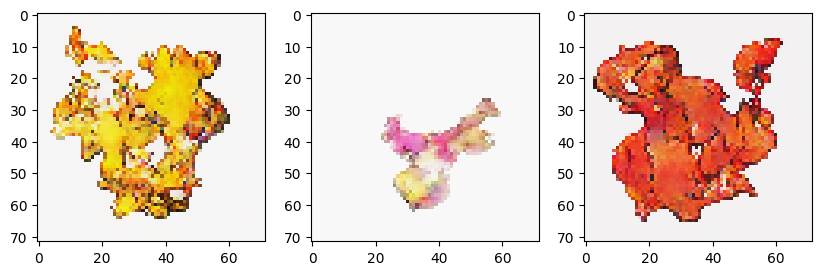

0.02030003:  17%|█▋        | 16999/100001 [12:45<55:45, 24.81it/s]   

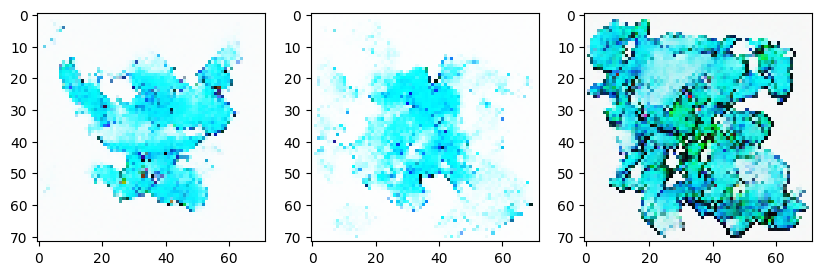

0.03001834:  18%|█▊        | 17998/100001 [13:30<55:03, 24.82it/s]   

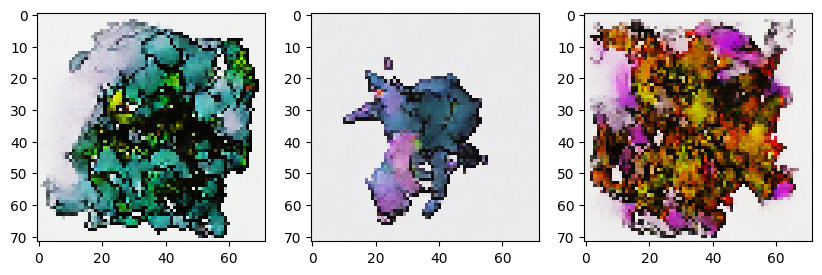

0.01598274:  19%|█▉        | 19000/100001 [14:15<54:36, 24.72it/s]   

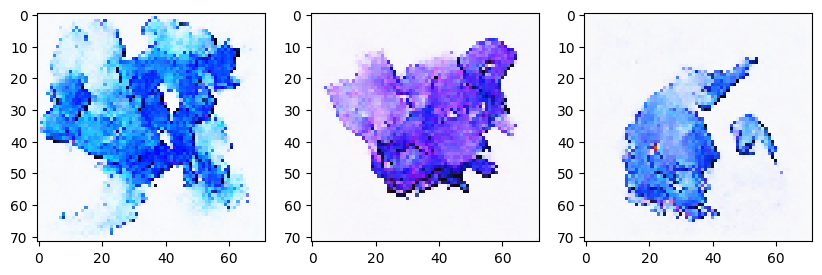

0.02721334:  20%|█▉        | 19999/100001 [15:00<53:44, 24.81it/s]   

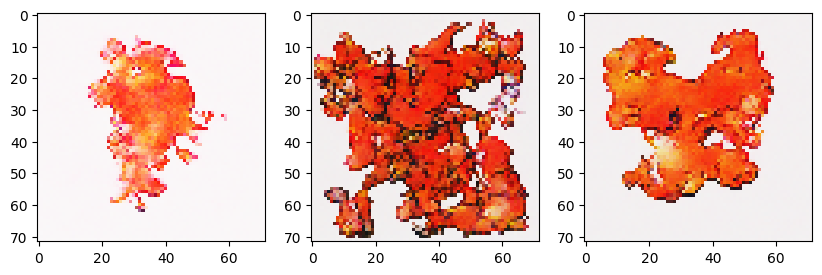

0.02930771:  21%|██        | 20998/100001 [15:45<53:13, 24.74it/s]   

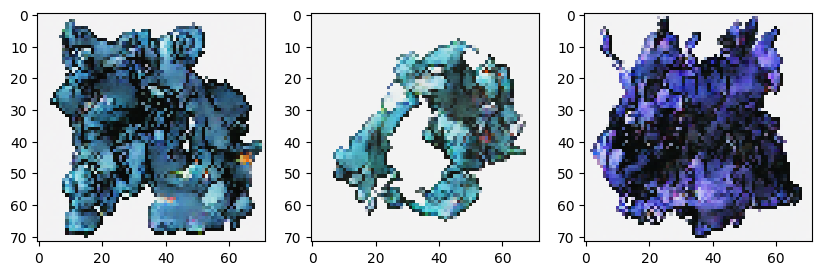

0.02470133:  22%|██▏       | 22000/100001 [16:30<52:21, 24.83it/s]   

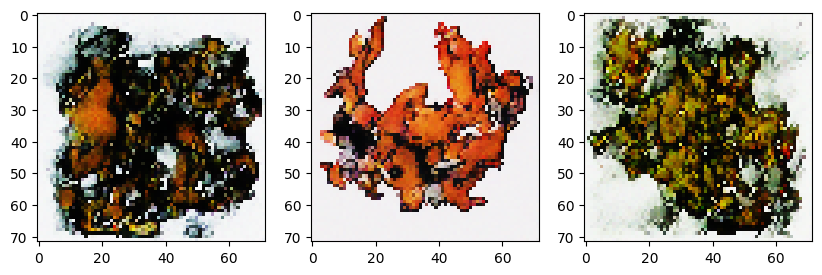

0.03429672:  23%|██▎       | 22999/100001 [17:15<51:40, 24.84it/s]   

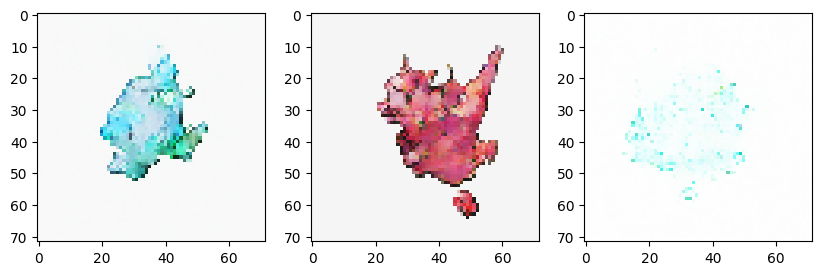

0.02200741:  24%|██▍       | 23998/100001 [18:00<50:54, 24.88it/s]   

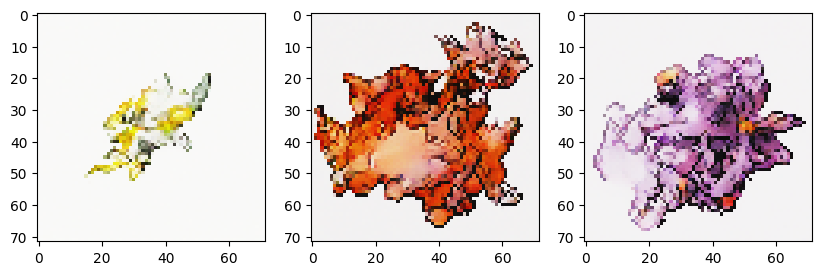

0.02689273:  25%|██▍       | 25000/100001 [18:46<50:25, 24.79it/s]   

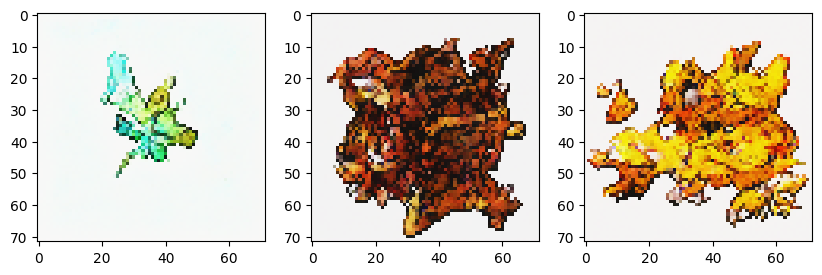

0.02410186:  26%|██▌       | 25999/100001 [19:31<49:48, 24.76it/s]   

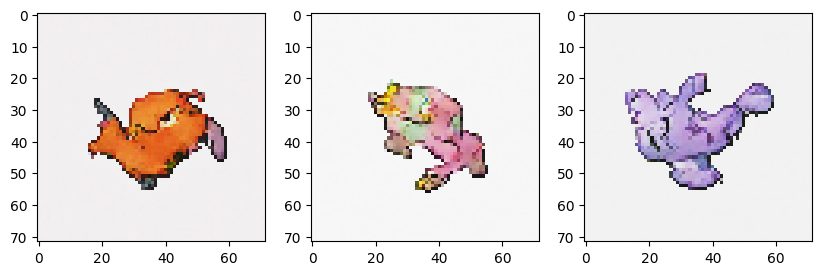

0.04109862:  27%|██▋       | 26998/100001 [20:16<49:07, 24.77it/s]   

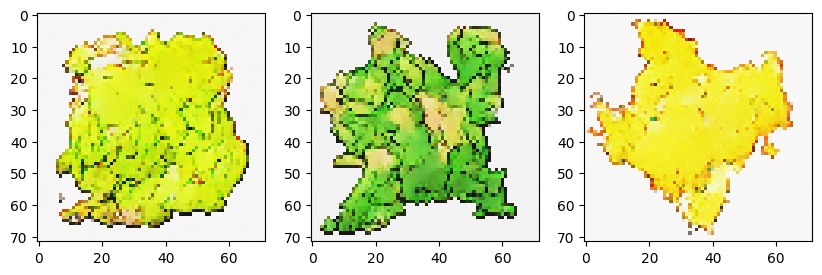

0.03628650:  28%|██▊       | 28000/100001 [21:01<48:25, 24.78it/s]   

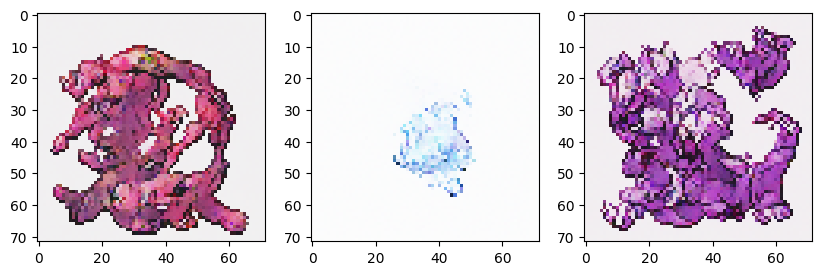

0.02712210:  29%|██▉       | 28999/100001 [21:46<47:46, 24.77it/s]   

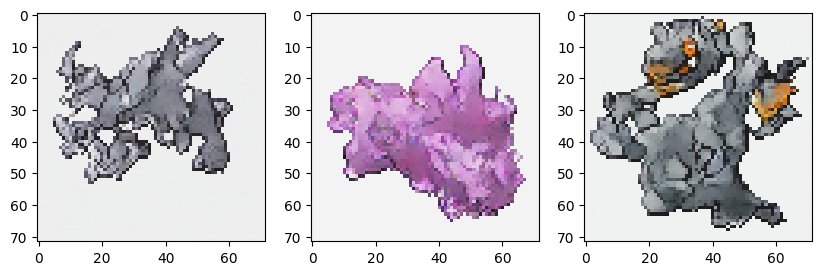

0.03378818:  30%|██▉       | 29998/100001 [22:31<46:38, 25.01it/s]   

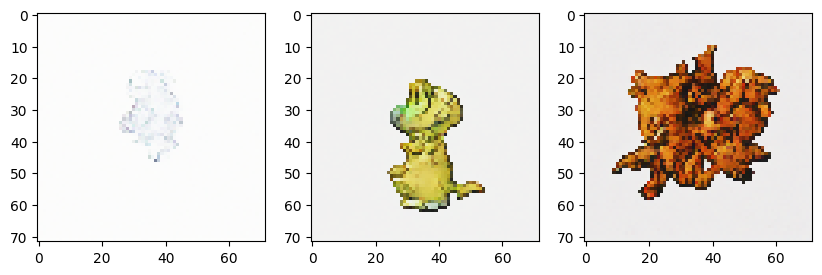

0.02164438:  31%|███       | 31000/100001 [23:16<46:25, 24.77it/s]  

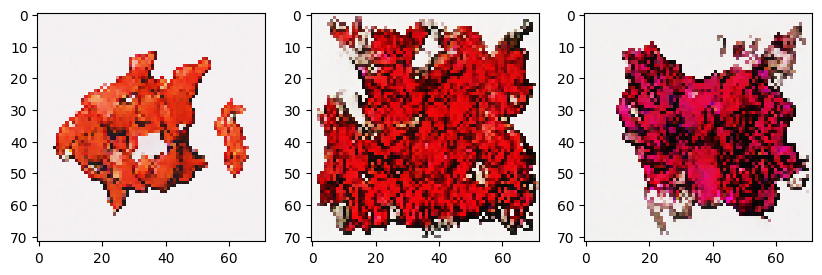

0.02461501:  32%|███▏      | 31999/100001 [24:01<45:45, 24.77it/s]  

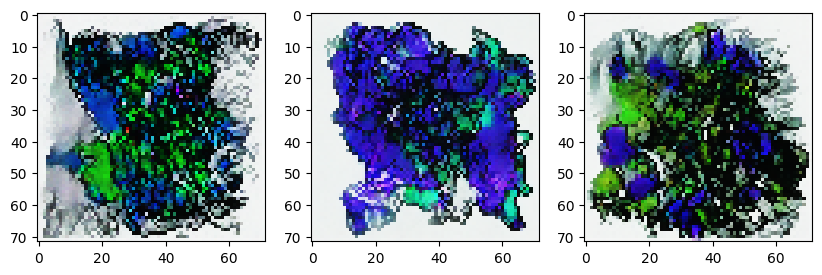

0.02323323:  33%|███▎      | 32998/100001 [24:46<45:02, 24.79it/s]  

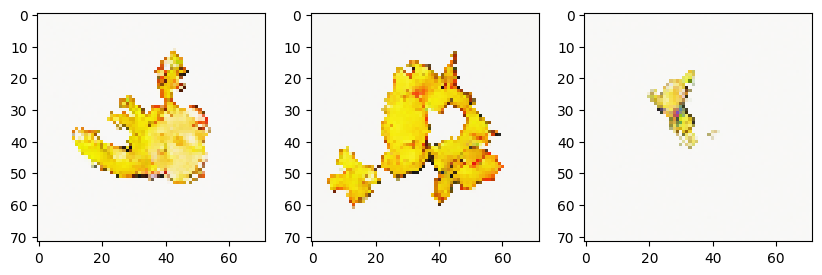

0.02838878:  34%|███▍      | 34000/100001 [25:31<44:13, 24.87it/s]  

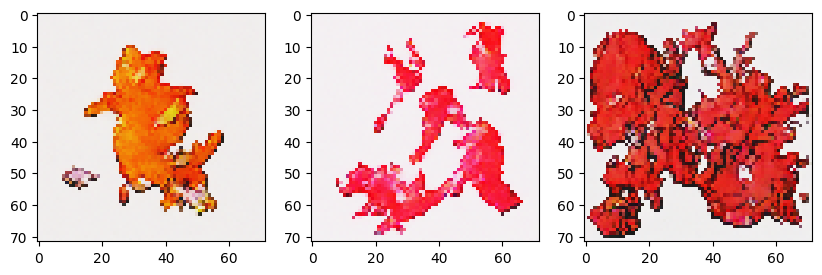

0.03005200:  35%|███▍      | 34999/100001 [26:16<43:47, 24.74it/s]  

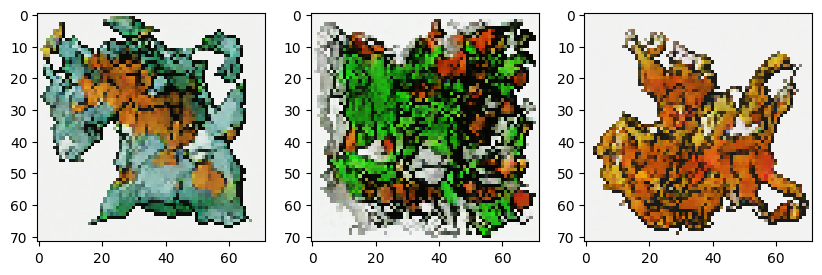

0.03117548:  36%|███▌      | 35998/100001 [27:01<42:47, 24.92it/s]  

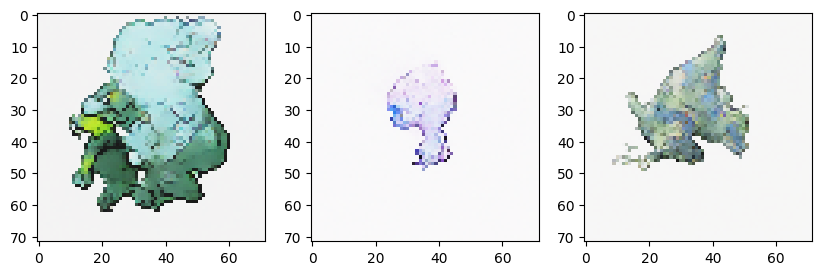

0.03814399:  37%|███▋      | 37000/100001 [27:46<42:20, 24.80it/s]  

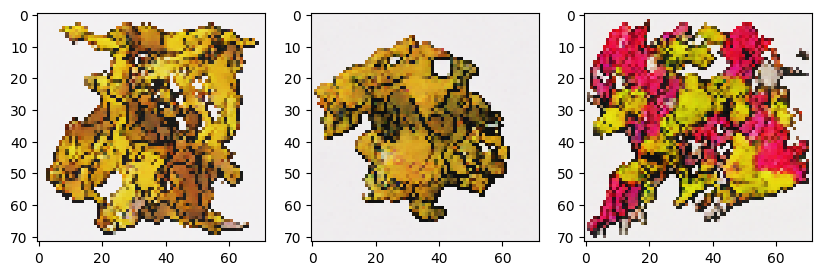

0.02865233:  38%|███▊      | 37999/100001 [28:31<41:36, 24.83it/s]  

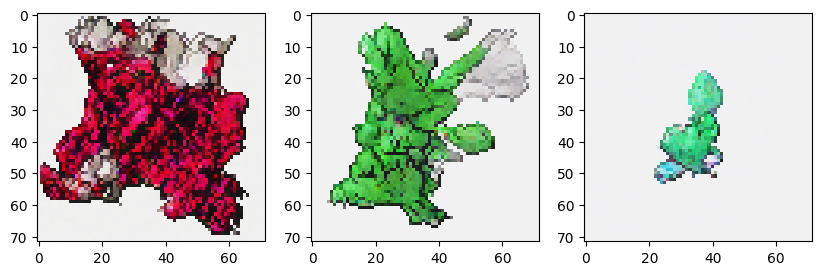

0.01973937:  39%|███▉      | 38998/100001 [29:16<41:01, 24.78it/s]  

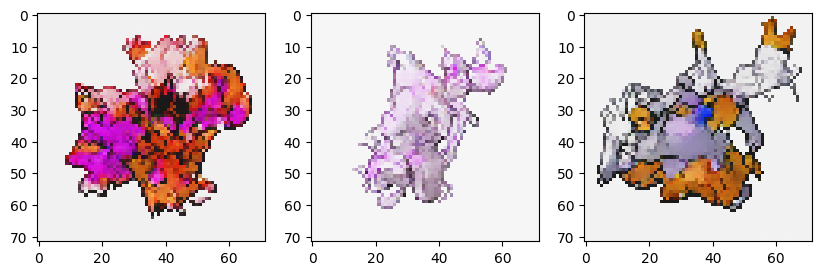

0.03870934:  40%|███▉      | 40000/100001 [30:01<40:21, 24.78it/s]  

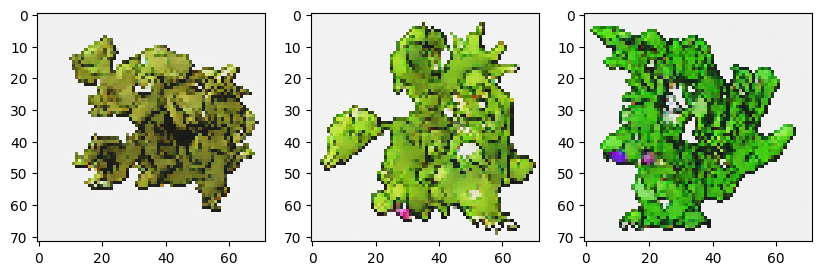

0.02056978:  41%|████      | 40999/100001 [30:46<39:42, 24.77it/s]  

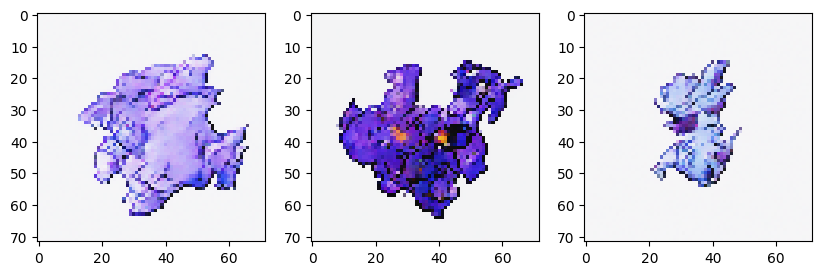

0.02921969:  42%|████▏     | 41998/100001 [31:32<38:58, 24.80it/s]  

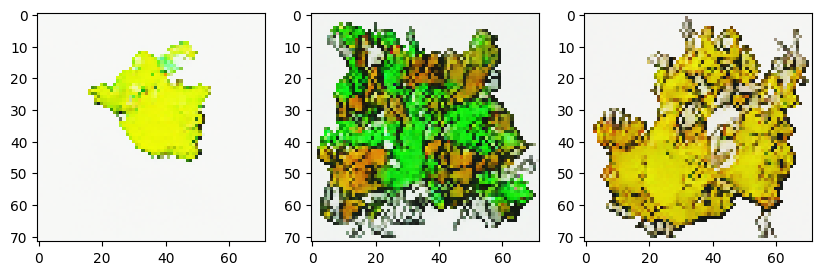

0.00879207:  43%|████▎     | 43000/100001 [32:17<38:19, 24.79it/s]  

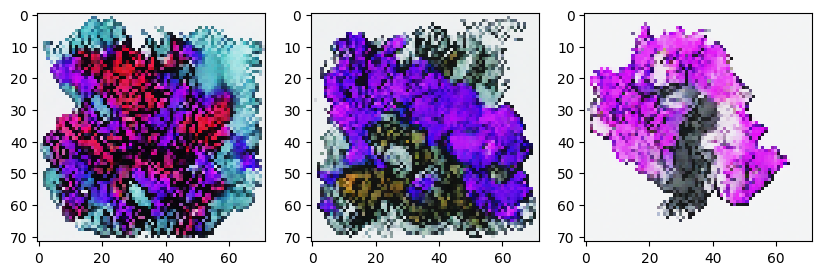

0.02196169:  44%|████▍     | 43999/100001 [33:02<37:42, 24.75it/s]  

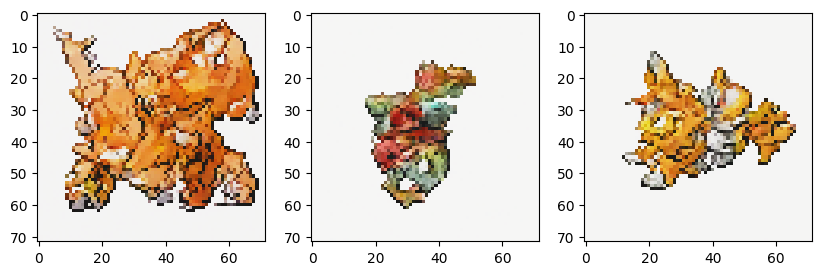

0.02148039:  45%|████▍     | 44998/100001 [33:47<36:58, 24.80it/s]  

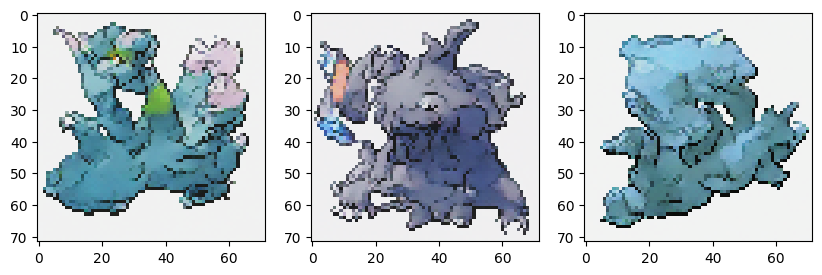

0.01195335:  46%|████▌     | 46000/100001 [34:32<36:08, 24.90it/s]  

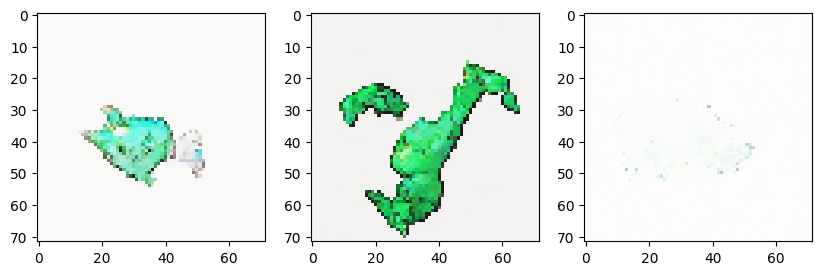

0.01830814:  47%|████▋     | 46999/100001 [35:17<35:33, 24.84it/s]  

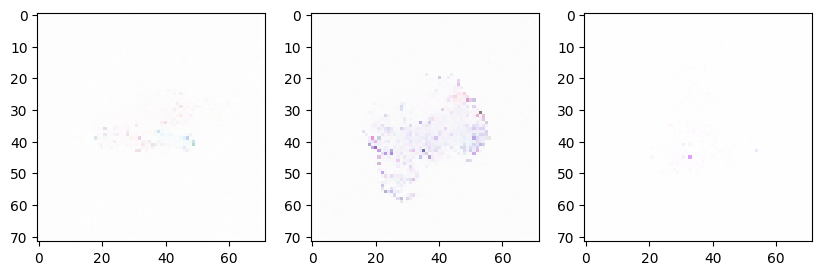

0.02674517:  48%|████▊     | 47998/100001 [36:02<34:55, 24.81it/s]  

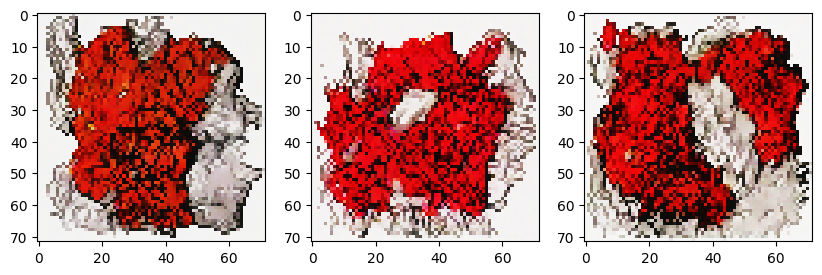

0.01035447:  49%|████▉     | 49000/100001 [36:47<34:15, 24.82it/s]  

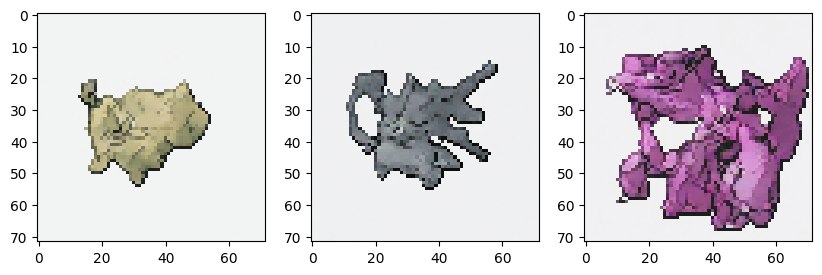

0.02736009:  50%|████▉     | 49999/100001 [37:32<33:39, 24.76it/s]  

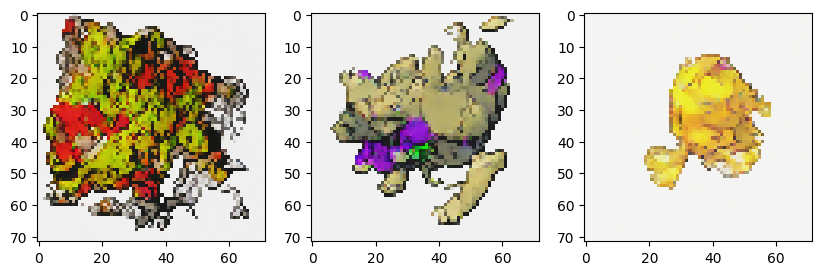

0.02831654:  51%|█████     | 50998/100001 [38:17<33:11, 24.61it/s]  

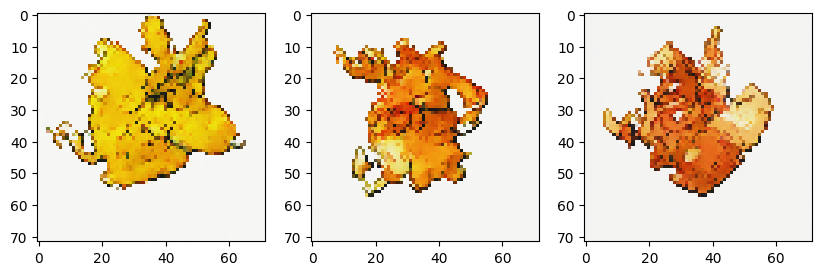

0.02627250:  52%|█████▏    | 52000/100001 [39:02<32:13, 24.83it/s]  

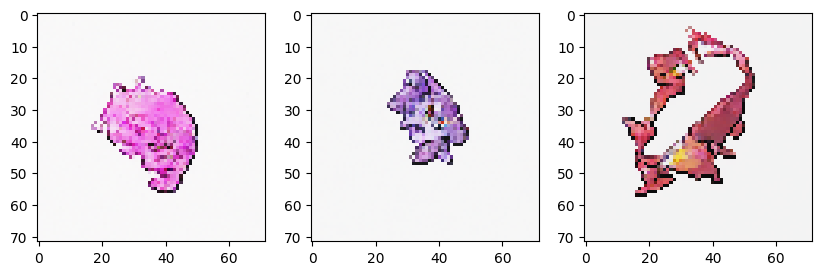

0.01063689:  53%|█████▎    | 52999/100001 [39:48<31:29, 24.88it/s]  

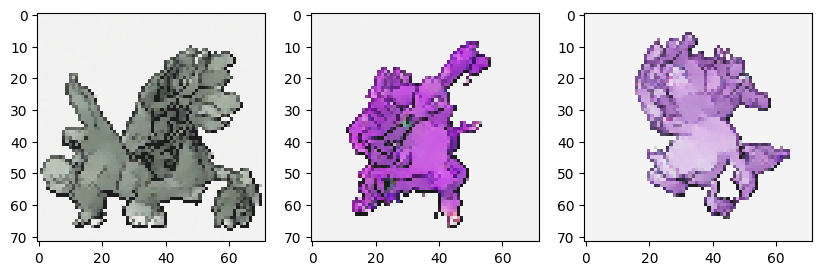

0.02901001:  54%|█████▍    | 53998/100001 [40:33<30:50, 24.86it/s]  

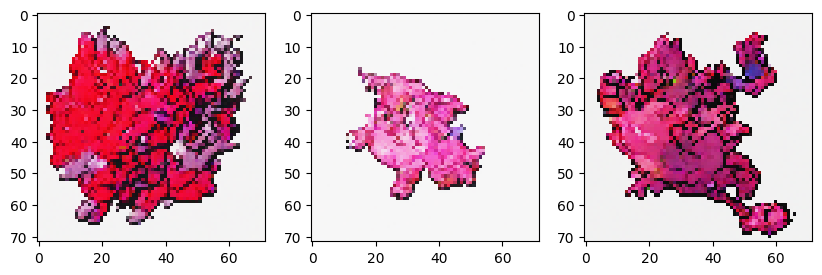

0.01955079:  55%|█████▍    | 55000/100001 [41:18<30:18, 24.75it/s]  

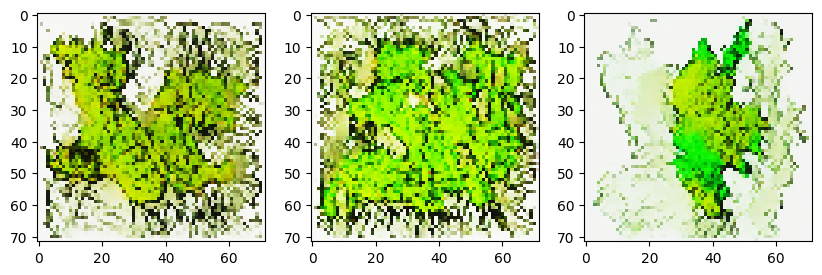

0.02021186:  56%|█████▌    | 55999/100001 [42:03<29:30, 24.85it/s]  

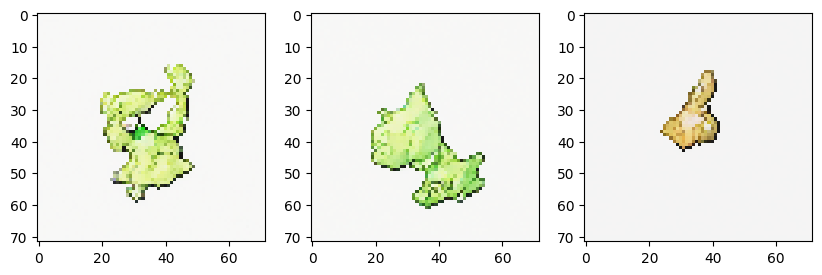

0.01971646:  57%|█████▋    | 56998/100001 [42:48<28:58, 24.74it/s]  

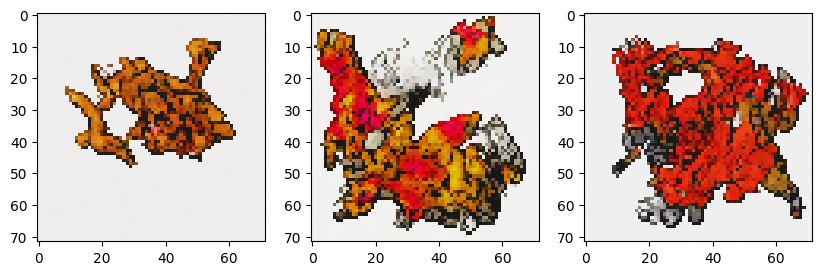

0.03673267:  58%|█████▊    | 58000/100001 [43:33<28:04, 24.93it/s]  

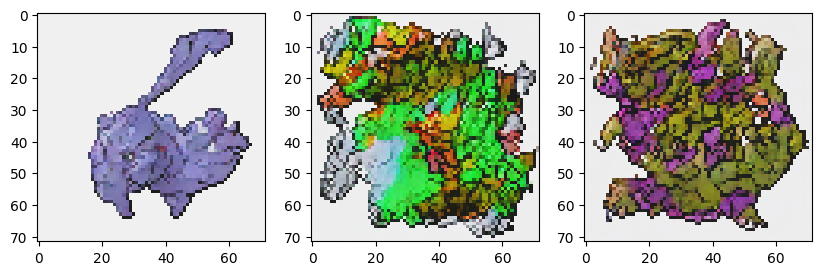

0.02046882:  59%|█████▉    | 58999/100001 [44:18<27:28, 24.88it/s]  

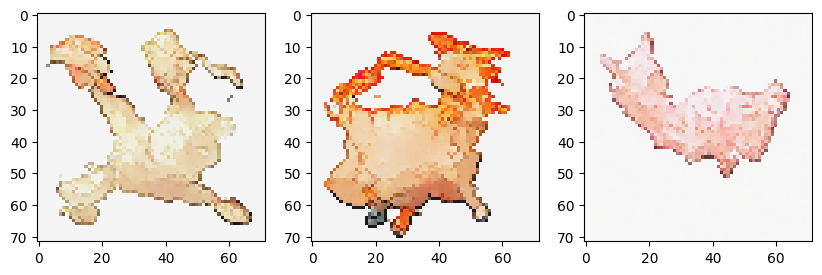

0.03081433:  60%|█████▉    | 59998/100001 [45:04<27:04, 24.62it/s]  

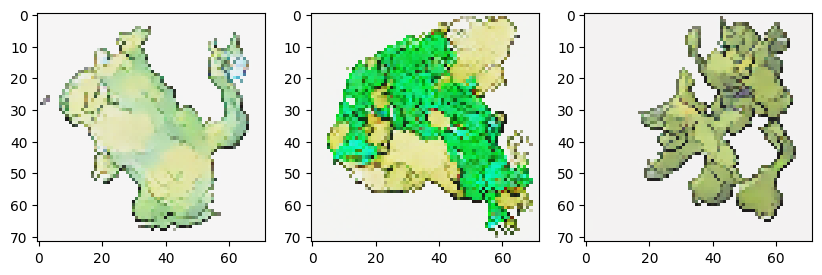

0.02860431:  61%|██████    | 61000/100001 [45:49<26:46, 24.28it/s]  

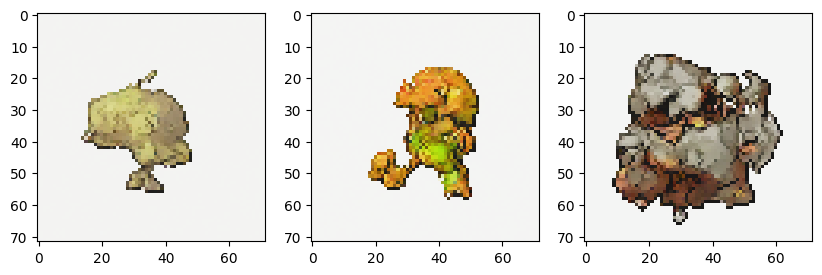

0.01655737:  62%|██████▏   | 61999/100001 [46:34<25:35, 24.74it/s]  

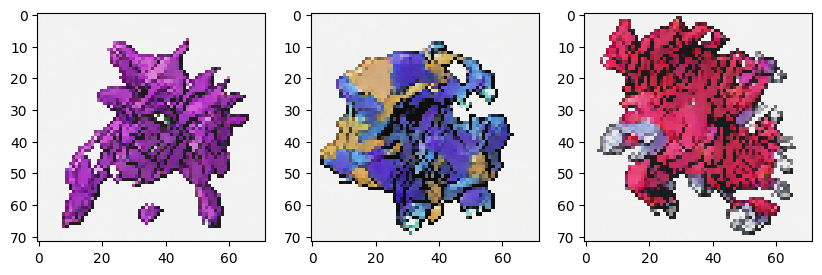

0.02218829:  63%|██████▎   | 62998/100001 [47:19<24:52, 24.78it/s]  

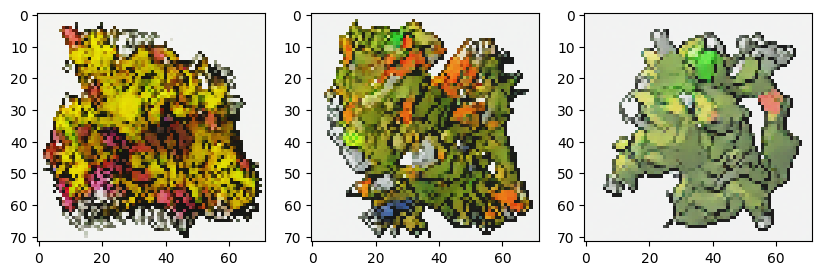

0.02421861:  64%|██████▍   | 64000/100001 [48:04<24:17, 24.71it/s]  

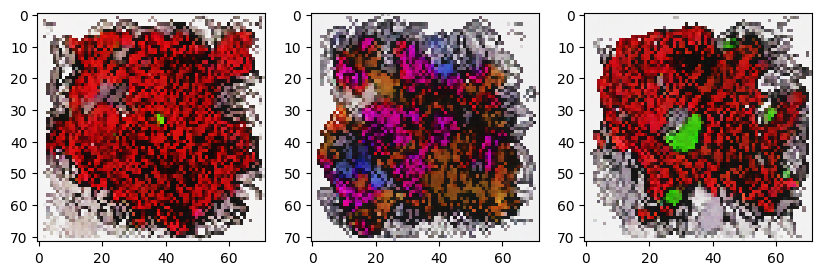

0.01692103:  65%|██████▍   | 64999/100001 [48:49<23:34, 24.74it/s]  

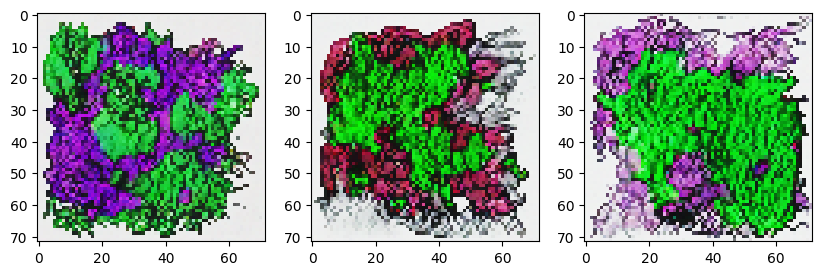

0.02348817:  66%|██████▌   | 65998/100001 [49:35<22:50, 24.81it/s]  

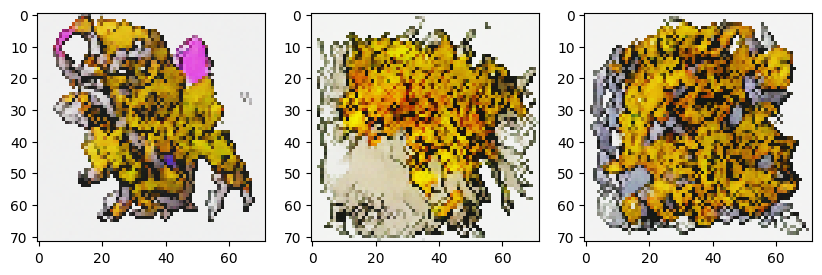

0.02089021:  67%|██████▋   | 67000/100001 [50:20<22:11, 24.78it/s]  

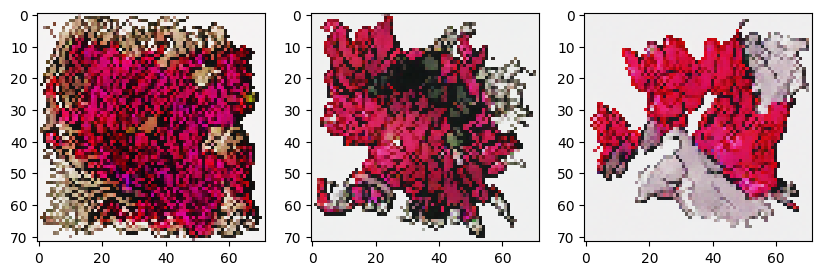

0.01693101:  68%|██████▊   | 67999/100001 [51:05<21:31, 24.77it/s]  

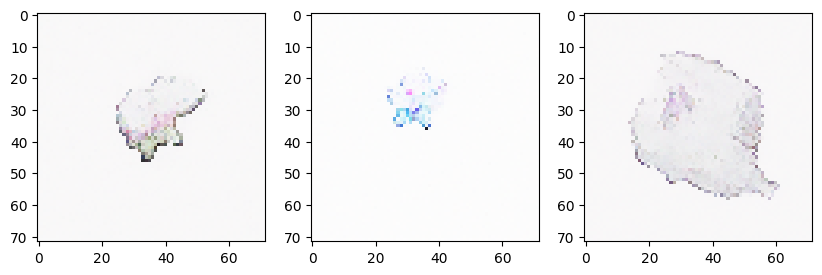

0.04291742:  69%|██████▉   | 68998/100001 [51:50<20:53, 24.74it/s]  

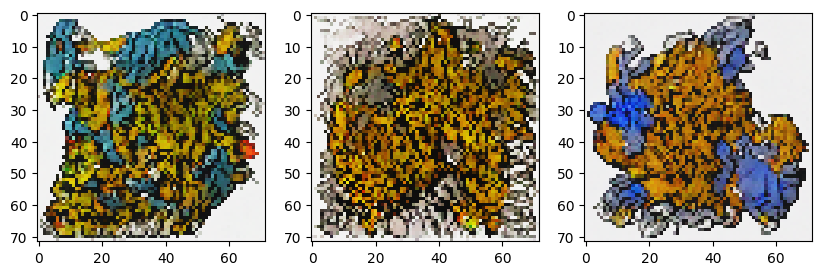

0.01745722:  70%|██████▉   | 70000/100001 [52:35<20:11, 24.76it/s]  

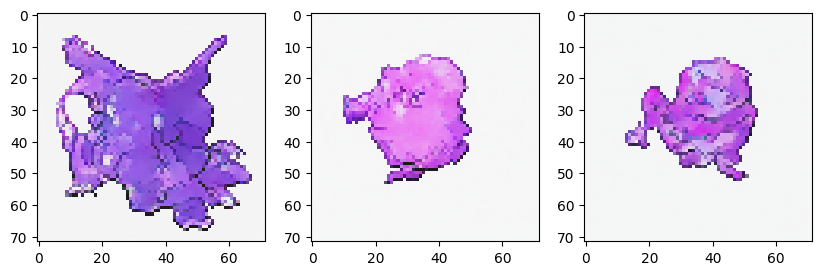

0.03468732:  71%|███████   | 70999/100001 [53:20<19:29, 24.81it/s]  

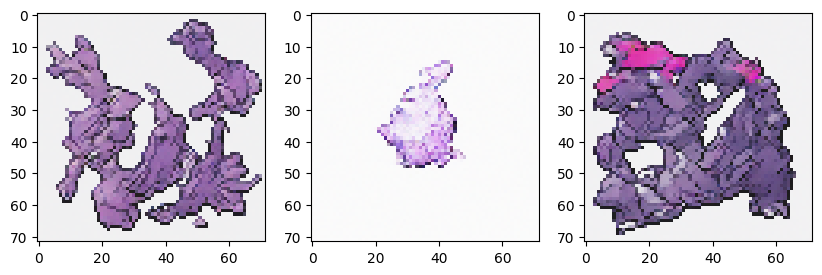

0.01811900:  72%|███████▏  | 71998/100001 [54:05<18:51, 24.74it/s]  

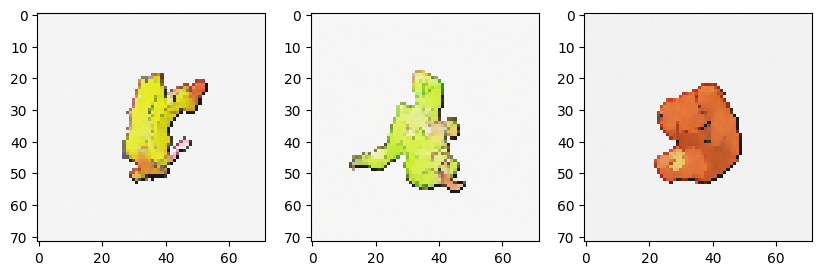

0.03096730:  73%|███████▎  | 73000/100001 [54:50<18:07, 24.84it/s]  

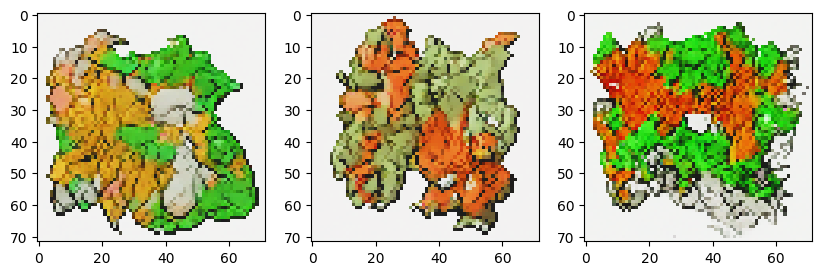

0.01592559:  74%|███████▍  | 73999/100001 [55:35<17:28, 24.81it/s]  

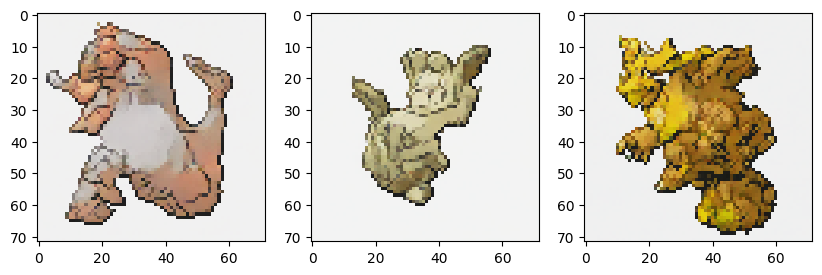

0.00686017:  75%|███████▍  | 74998/100001 [56:20<16:46, 24.84it/s]  

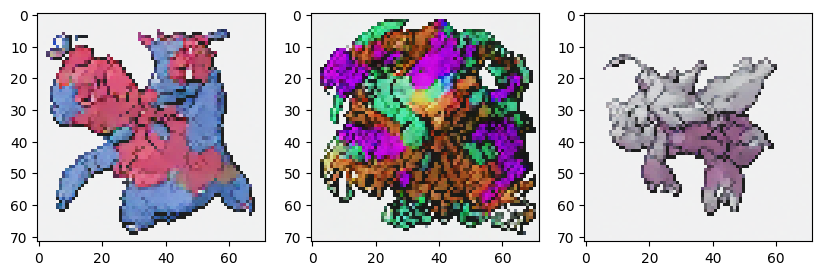

0.01762790:  76%|███████▌  | 76000/100001 [57:05<16:08, 24.78it/s]  

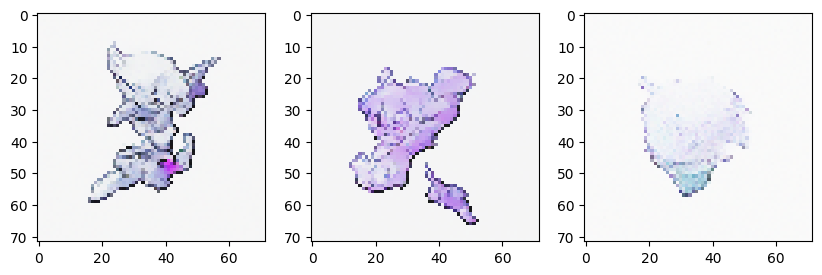

0.02509234:  77%|███████▋  | 76999/100001 [57:50<15:27, 24.80it/s]  

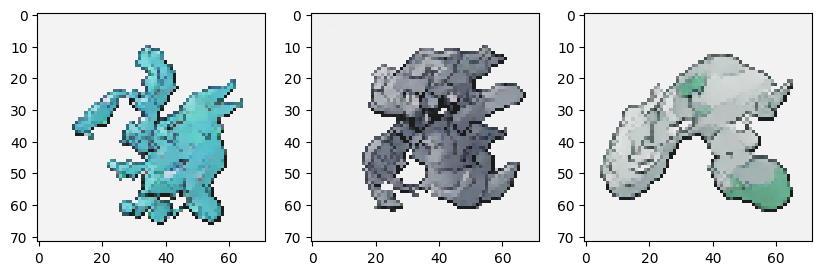

0.01787526:  78%|███████▊  | 77998/100001 [58:35<14:44, 24.88it/s]  

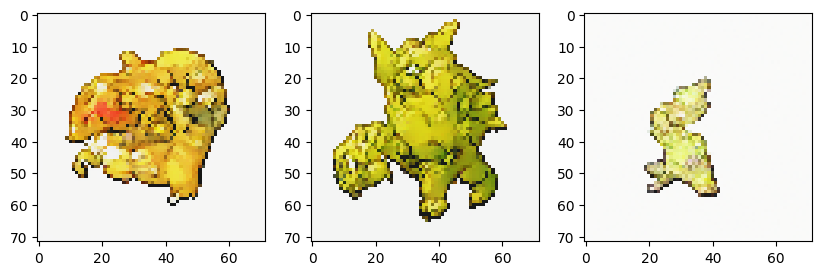

0.02719142:  79%|███████▉  | 79000/100001 [59:20<14:05, 24.83it/s]  

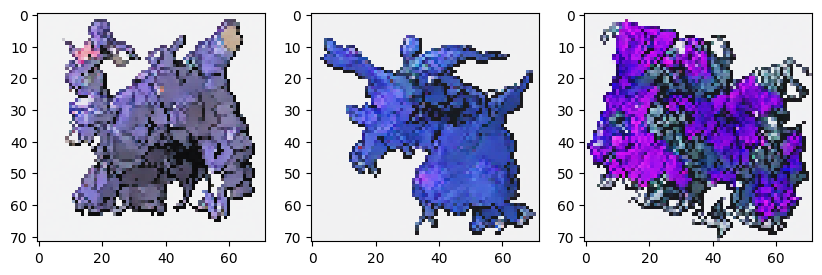

0.01458352:  80%|███████▉  | 79999/100001 [1:00:05<13:29, 24.72it/s]

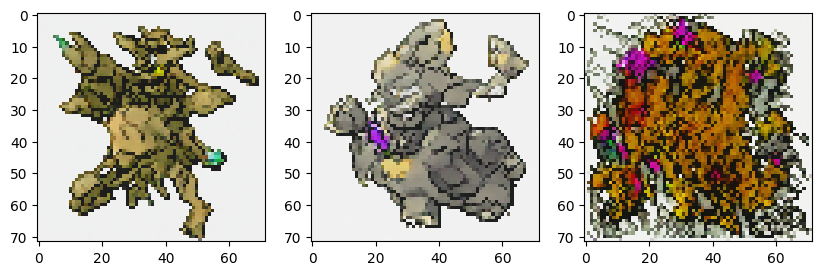

0.01246778:  81%|████████  | 80998/100001 [1:00:50<12:44, 24.87it/s]  

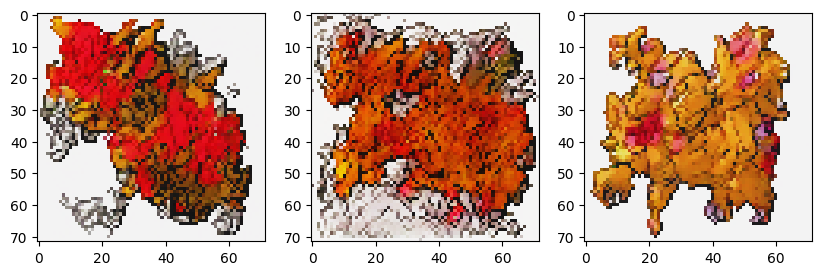

0.01788178:  82%|████████▏ | 82000/100001 [1:01:35<12:07, 24.73it/s]  

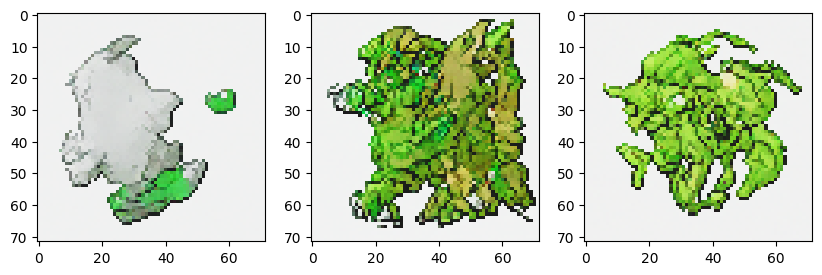

0.01606081:  83%|████████▎ | 82999/100001 [1:02:20<11:26, 24.76it/s]  

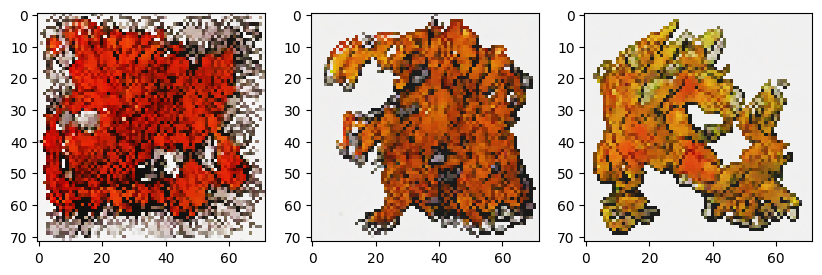

0.01793234:  84%|████████▍ | 83998/100001 [1:03:05<10:47, 24.71it/s]  

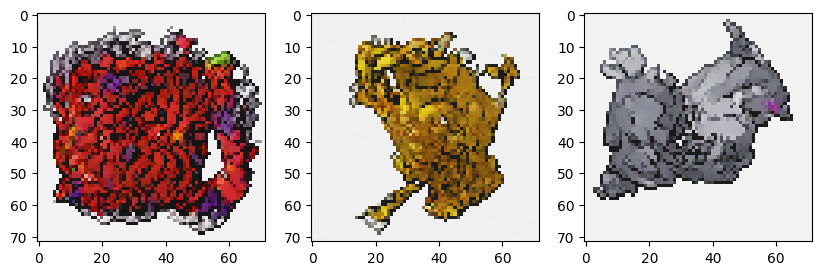

0.02620813:  85%|████████▍ | 85000/100001 [1:03:50<10:06, 24.75it/s]  

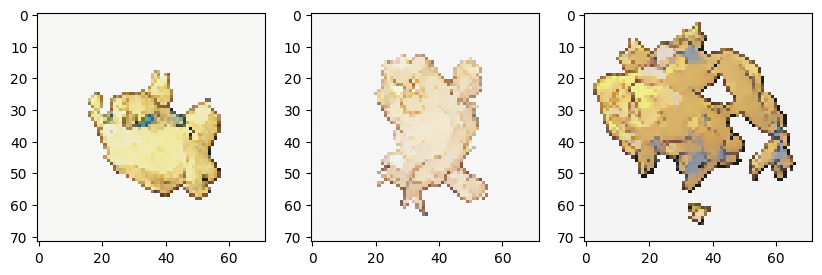

0.01963866:  86%|████████▌ | 85999/100001 [1:04:35<09:24, 24.81it/s]  

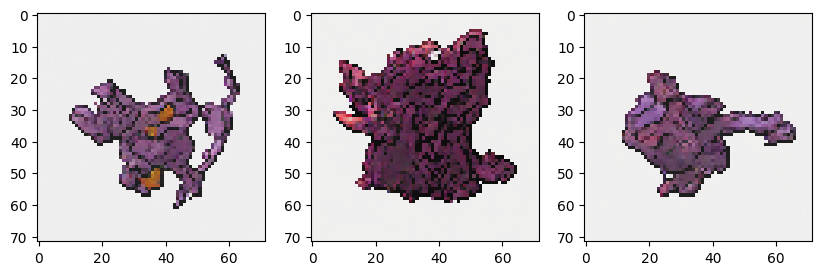

0.01771021:  87%|████████▋ | 86998/100001 [1:05:21<08:44, 24.79it/s]  

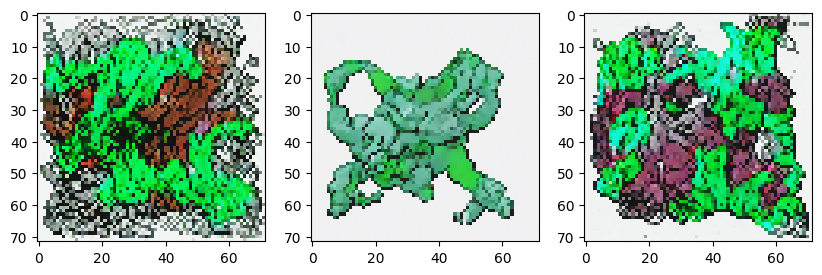

0.02234717:  88%|████████▊ | 88000/100001 [1:06:06<08:01, 24.92it/s]  

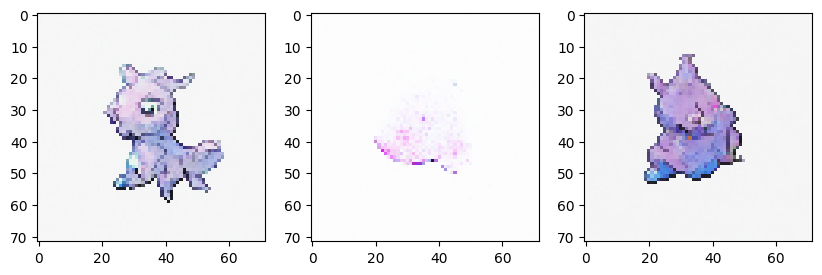

0.02294663:  89%|████████▉ | 88999/100001 [1:06:51<07:24, 24.78it/s]  

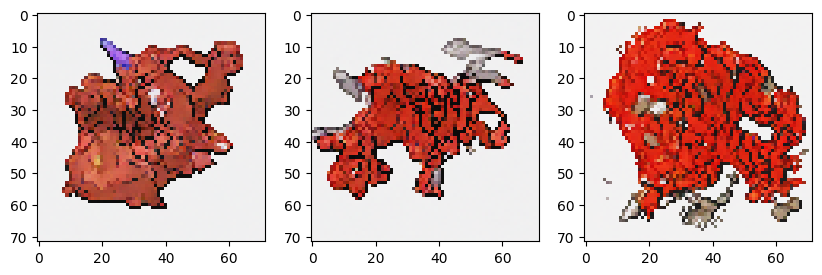

0.02397725:  90%|████████▉ | 89998/100001 [1:07:36<06:41, 24.89it/s]  

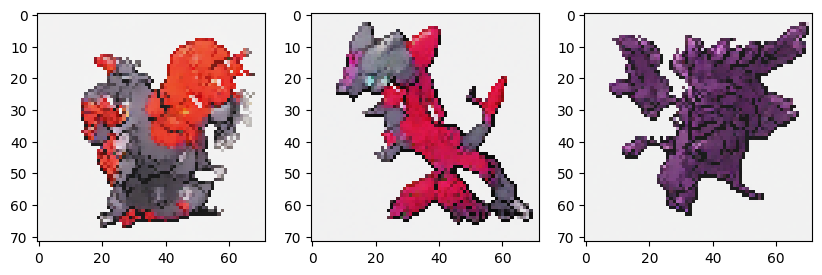

0.01262543:  91%|█████████ | 91000/100001 [1:08:21<06:01, 24.87it/s]  

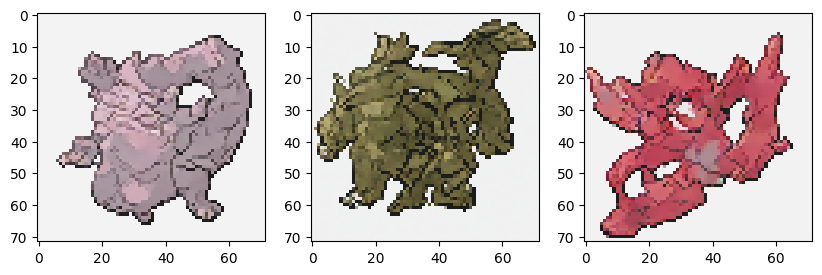

0.01559342:  92%|█████████▏| 91999/100001 [1:09:06<05:22, 24.78it/s]  

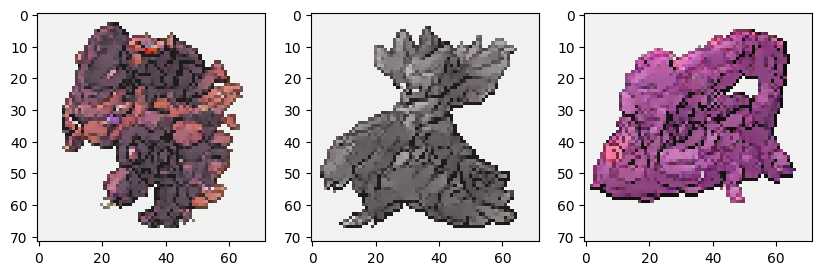

0.00777206:  93%|█████████▎| 92998/100001 [1:09:51<04:42, 24.78it/s]  

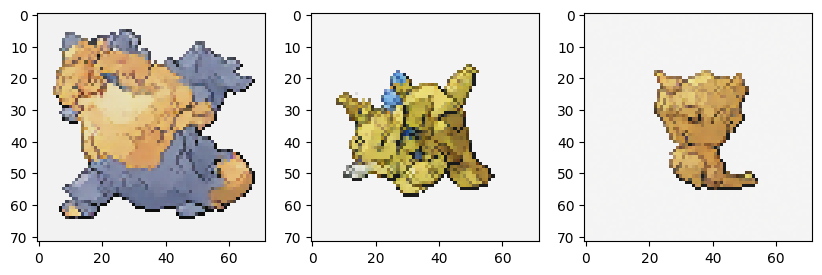

0.01739723:  94%|█████████▍| 94000/100001 [1:10:36<04:01, 24.83it/s]

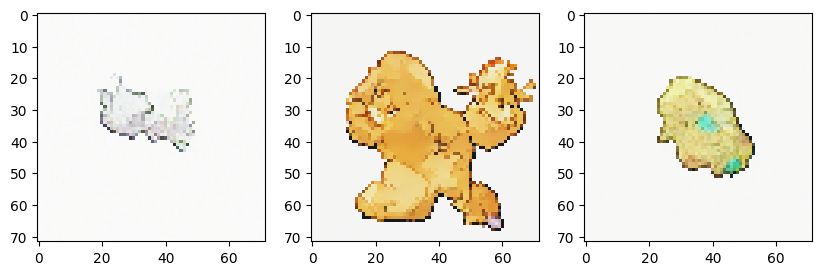

0.02957346:  95%|█████████▍| 94999/100001 [1:11:21<03:21, 24.78it/s]

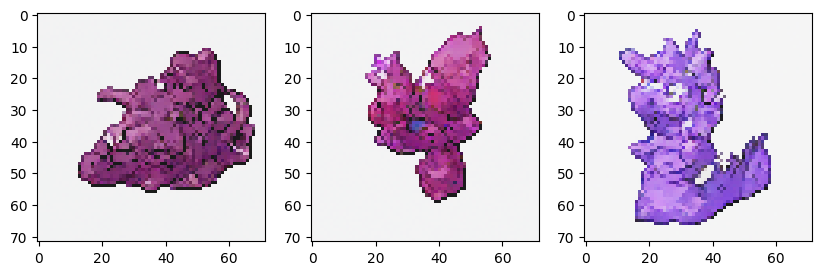

0.02452359:  96%|█████████▌| 95998/100001 [1:12:06<02:40, 24.88it/s]

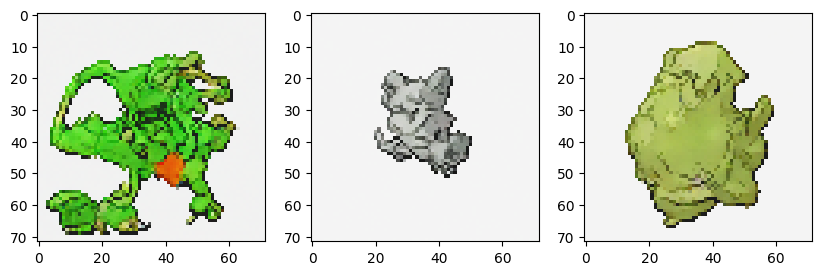

0.01641425:  97%|█████████▋| 97000/100001 [1:12:51<02:01, 24.78it/s]

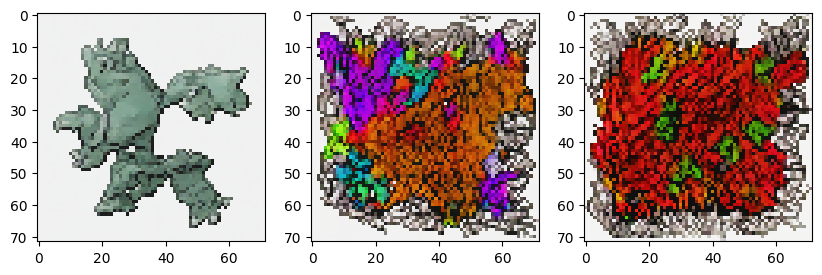

0.01829343:  98%|█████████▊| 97999/100001 [1:13:36<01:20, 24.80it/s]

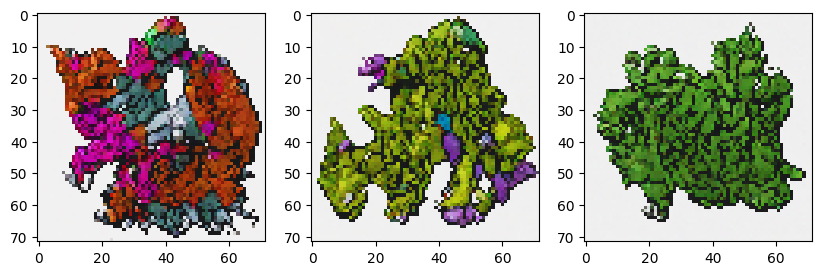

0.01142781:  99%|█████████▉| 98998/100001 [1:14:21<00:40, 24.80it/s]

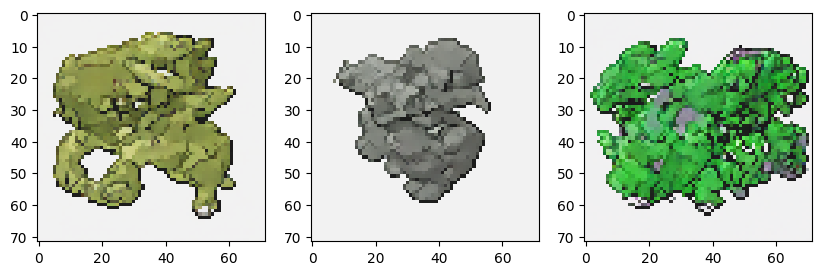

0.02553418: 100%|█████████▉| 100000/100001 [1:15:06<00:00, 24.84it/s]

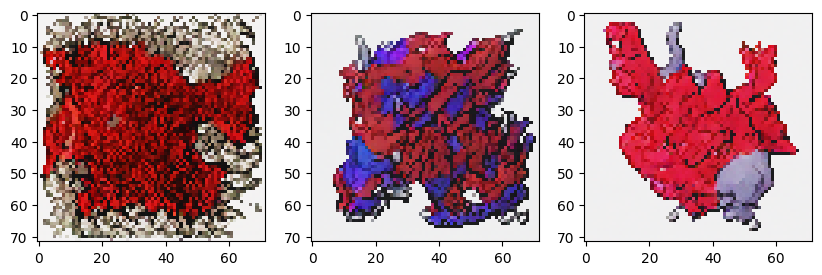

0.01705836: 100%|██████████| 100001/100001 [1:15:11<00:00, 22.17it/s]


In [8]:
model = UNet(3, 3, time_dim=256, num_classes=len(all_types) + 1).to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-4)

loss_func = nn.MSELoss()

pbar = tqdm(range(100001))
def closure():
    optimizer.zero_grad()

    bs = 16

    source = torch.randint(0, 2, (bs,))
    batch = torch.randperm(385)[:bs]
    
    x0 = pimages[source, batch]
    c = contour[source, batch]

    xc = torch.cat([x0, c], dim=1)
    xc = torch.stack([pos_transform(x) for x in xc], dim=0)
    
    x0 = xc[:, :-1]
    c = xc[:, [-1]]

    x0 = torch.stack([col_transform(x) for x in x0], dim=0)
    x0 = isigmoid(x0)

    ty = types[batch]

    e = torch.randn_like(x0)
    t = torch.randint(0, T - 1, (bs,), device=device)

    xt = torch.sqrt(alpha_[t])[:, None, None, None] * x0 + torch.sqrt(1-alpha_[t])[:, None, None, None] * e
    ep = model(xt, t, ty, c)

    loss = loss_func(ep, e)
    loss.backward()
    
    pbar.set_description(f"%.8f" % loss, refresh=False)
    
    return loss

model.train()
for j in pbar:
    optimizer.step(closure)

    if j % 1000 == 0:
        generate_image()

torch.save(model.state_dict(), 'model.pt')